## 1 Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import lightgbm as lgb

# tuning
from datetime import datetime
from functools import partial
import optuna

pd.set_option('display.max_columns', None)

In [15]:
logTarget = False
logArea = True

## 2 Data Load

In [3]:
folder = 'data/'
dt = pd.read_csv(folder+'train.csv')
dt_test = pd.read_csv(folder+'test.csv')

## 3 Data Processing

### 3.1 Data Preprocessing

In [17]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1

concat = pd.concat([dt, dt_test]).reset_index(drop=True)     # 하나의 데이터로 만들어줍니다.

In [18]:
# 컬럼 이름 변경
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [19]:
# 사용하지 않을 컬럼 제거
concat_select = concat.drop(columns=['해제사유발생일', '등기신청일자', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob',
       'k-사용검사일-사용승인일','k-홈페이지','k-등록일자', '고용보험관리번호', '경비비관리형태', '청소비관리형태',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '단지신청일',
       'k-135㎡초과', '관리비 업로드',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-수정일자', '건축면적', 
       ])

In [20]:
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [21]:
def parted_area(x):
    if x <= 40:
        return 0
    elif x <= 60:
        return 1
    elif x <= 85:
        return 2
    elif x <= 135:
        return 3
    else:
        return 4

concat_select['전용면적범주'] = concat_select['전용면적'].apply(parted_area)

### 3.2 외부데이터

#### 3.1.1 금리 데이터

In [22]:
base_df = pd.read_csv(folder+'base_rate.csv')

In [23]:
base_df.drop(columns=['통계표', '단위', '변환'], inplace=True)

base_df.columns = [''.join(x) for x in base_df.columns.str.split('/')]

base_df = pd.melt(base_df, id_vars=['계정항목'], var_name='년월', value_name='금리')
base_df['년월'] = base_df['년월'].astype(np.int32)

base_df = base_df.pivot(index='년월', columns='계정항목', values='금리').reset_index()

base_df = base_df[['년월', '정부대출금금리', '한국은행 기준금리'] ]
base_df.columns = ['계약년월', '대출금리', '기준금리']

# 평가데이터의 금리는 학습데이터 기준 가장 최근과 동일하게 설정
base_df.loc[base_df['계약년월'] > 202306,'대출금리'] = base_df[base_df['계약년월'] == 202306]['대출금리'].iloc[0]
base_df.loc[base_df['계약년월'] > 202306,'기준금리'] = base_df[base_df['계약년월'] == 202306]['기준금리'].iloc[0]

concat_select = concat_select.merge(base_df, how='left', on='계약년월')

#### 3.1.2 아파트 단지 정보 데이터
- 아파트 단지 데이터와 train 데이터에서 겹치는 컬럼을 결측치를 채우는데 이용합니다.
- 또한 단지 정보 데이터에서 활용할 수 있는 새로운 컬럼들도 추가해줍니다.

In [24]:
basic_apart = pd.read_parquet(folder+'basic_apart.parquet')

In [25]:
basic_apart = basic_apart[basic_apart['시도'] == '서울특별시']
concat_select['아파트주소'] = concat_select['시군구'] + " " + concat_select['번지']
basic_apart['법정주소'] = basic_apart['법정동주소'].str.split(",").str[0]
basic_apart['아파트주소'] = basic_apart['법정주소'].str.split(" ").str[0:4].apply(lambda x: " ".join(x))

""" 
승강기 갯수에 대한 정보는 '승강기(승객용)', '승강기(화물용)' 컬럼을 합쳐도 승강기(승객+화물)와 다르다거나
'승강기(승객용)', '승강기(화물용)', '승강기(승객+화물)' 컬럼이 모두 0인데 '승강기(장애인)' 컬럼의 승강기 갯수가 높다거나
데이터가 무분별하게 입력돼 있다고 판단하여 가장 큰 값만 가져와 활용합니다.
"""
basic_apart['승강기'] = basic_apart[['승강기(승객용)', '승강기(화물용)', '승강기(승객+화물)','승강기(장애인)', '승강기(비상용)', '승강기(기타)']].max(axis=1)

In [26]:
basic_apart['차량보유대수(전체)'] = basic_apart['차량보유대수(전체)'].astype('Int64')
basic_apart['차량보유대수(전기차)'] = basic_apart['차량보유대수(전기차)'].astype('Int64')

basic_apart['전기차전용주차면수(지상)'] = basic_apart['전기차전용주차면수(지상)'].replace("해당없음", "0")
basic_apart['전기차전용주차면수(지하)'] = basic_apart['전기차전용주차면수(지하)'].replace("해당없음", "0")

basic_apart['전기차전용주차면수(지상)'] = basic_apart['전기차전용주차면수(지상)'].astype("Int64")
basic_apart['전기차전용주차면수(지하)'] = basic_apart['전기차전용주차면수(지하)'].astype(float)

basic_apart['전기충전기설치여부(지상)'] = basic_apart['전기충전기설치여부(지상)'].map({"해당없음":0, "설치":1}).astype("Int64")
basic_apart['전기충전기설치여부(지하)'] = basic_apart['전기충전기설치여부(지하)'].map({"해당없음":0, "설치":1}).astype("Int64")
basic_apart['전기충전기설치여부'] = basic_apart['전기충전기설치여부(지상)'] | basic_apart['전기충전기설치여부(지하)']

# 전기차전용주차면수(지하) 컬럼 이상치 처리
basic_apart.loc[basic_apart['단지코드'] == "A10023343", '전기차전용주차면수(지하)'] = basic_apart.loc[basic_apart['단지코드'] == "A10023343", '총주차대수']

basic_apart['전기차전용주차면수(지하)'] = basic_apart['전기차전용주차면수(지하)'].astype('Int64')
basic_apart['전기차전용주차면수'] = basic_apart['전기차전용주차면수(지상)'] + basic_apart['전기차전용주차면수(지하)']

##### 중복값 처리
아파트단지정보 데이터에서 아파트주소(시군구+번지)를 key값으로 train 데이터와 병합해줄 것이기 때문에 아파트주소가 unique한 값을 가지도록 중복값을 처리합니다.
- case1: 동일한 주소에 다른아파트가 여러개인 경우 => 엉뚱한 데이터가 병합될 위험이 있기 때문에 그냥 제거해줍니다.
- case2: 같은 아파트이지만 분양과 입대에 대한 데이터가 따로 존재하는경우 => 적절한 통계함수를 적용해서 두 데이터를 합쳐줍니다.

In [27]:
basic_du = basic_apart[basic_apart.duplicated(subset='아파트주소', keep=False)]
basic_du['이전분양형태'] = basic_du.groupby('아파트주소')['분양형태'].shift(-1)
basic_du = basic_du[~((basic_du['분양형태'].str.contains("분양|혼합")) & basic_du['이전분양형태'].str.contains("분양|혼합"))]

basic_apart.drop_duplicates(subset='아파트주소', keep=False, inplace=True)

In [28]:
# 사용할 컬럼만 선택합니다.
selected = ['분양형태', '법정주소', '단지명', '동수', '세대수', '분양세대수', '임대세대수', '관리방식', '난방방식', '복도유형', '시공사', '시행사',
'일반관리-관리방식', '일반관리-인원', '경비관리-관리방식', '경비관리-인원', '청소관리-관리방식', '청소관리-인원', '건물구조', '전기-수전용량', '전기-세대전기계약방식',
'승강기', '총주차대수', '지상주차대수', '지하주차대수', 'CCTV대수', '부대복리시설', '최고층수','지하층수', '차량보유대수(전체)',
'차량보유대수(전기차)', '전기충전기설치여부(지상)', '전기충전기설치여부(지하)','전기차전용주차면수(지상)','전기차전용주차면수(지하)', '아파트주소']

In [29]:
# case2에 관하여 어떻게 데이터를 합쳐줄지에 대한 통계함수입니다.
AGGREGATIONS = {
    '분양형태': 'first',
    '법정주소': 'first',
    '단지명': 'first',
    '동수': 'sum',
    '세대수': 'sum',
    '분양세대수': 'sum',
    '임대세대수': 'sum',
    '관리방식': 'first',
    '난방방식': 'first',
    '복도유형': 'first',
    '시공사': 'first',
    '시행사': 'first',
    '일반관리-인원': 'sum',
    '청소관리-인원': 'sum',
    '전기-수전용량': 'sum',
    '전기-세대전기계약방식': 'first',
    '승강기': 'sum',
    '총주차대수': 'sum',
    '지상주차대수': 'sum',
    '지하주차대수': 'sum',
    'CCTV대수': 'sum',
    '부대복리시설': 'first',
    '최고층수': 'max',
    '지하층수': 'max',
    '차량보유대수(전체)': 'sum',
    '차량보유대수(전기차)': 'sum',
    '전기충전기설치여부(지상)': 'max',
    '전기충전기설치여부(지상)': 'max',
    '전기차전용주차면수(지상)': 'sum',
    '전기차전용주차면수(지하)': 'sum',
}

basic_du = basic_du[selected].groupby('아파트주소').agg(AGGREGATIONS).reset_index()
basic_du['분양형태'] = '혼합'

basic_apart = pd.concat([basic_apart, basic_du], axis=0)
concat_merge = concat_select.merge(basic_apart[selected], how='left', on='아파트주소')

##### 결측값 채우기

In [30]:
# 결측값을 채워줄 컬럼들입니다.
['k-세대타입(분양형태)', '분양형태', 
 'k-관리방식', '관리방식',
 'k-복도유형','복도유형', 
 'k-난방방식', '난방방식', 
 'k-전체동수', '동수', 
 'k-전체세대수', '세대수', 
 'k-건설사(시공사)', '시공사', 
 'k-시행사', '시행사', 
 '세대전기계약방법', '전기-세대전기계약방식', 
 '주차대수', '총주차대수',]

['k-세대타입(분양형태)',
 '분양형태',
 'k-관리방식',
 '관리방식',
 'k-복도유형',
 '복도유형',
 'k-난방방식',
 '난방방식',
 'k-전체동수',
 '동수',
 'k-전체세대수',
 '세대수',
 'k-건설사(시공사)',
 '시공사',
 'k-시행사',
 '시행사',
 '세대전기계약방법',
 '전기-세대전기계약방식',
 '주차대수',
 '총주차대수']

In [31]:
# 카테고리가 다른 컬럼 같도록 맵핑해주기
concat_merge['분양형태'] = concat_merge['분양형태'].map({"분양": "분양", "혼합": "기타", "임대": "임대"})
index = concat_merge[concat_merge['k-세대타입(분양형태)'].isna()].index
concat_merge.loc[index, 'k-세대타입(분양형태)'] = concat_merge.loc[index, '분양형태']

# 카테고리가 다른 컬럼 같도록 맵핑해주기
concat_merge['관리방식'] = concat_merge['관리방식'].map({"위탁관리": "위탁관리", "자치관리": "자치관리", "위탁관리(직영+위탁)": "직영", "자치관리(직영)": "직영", "위탁관리(총액관리제)": "직영", "관리방식미정":np.nan})
index = concat_merge[concat_merge['k-관리방식'].isna()].index
concat_merge.loc[index, 'k-관리방식'] = concat_merge.loc[index, '관리방식']

index = concat_merge[concat_merge['k-복도유형'].isna()].index
concat_merge.loc[index, 'k-복도유형'] = concat_merge.loc[index, '복도유형']

index = concat_merge[concat_merge['k-난방방식'].isna()].index
concat_merge.loc[index, 'k-난방방식'] = concat_merge.loc[index, '난방방식']

index = concat_merge[concat_merge['k-전체동수'].isna()].index
concat_merge.loc[index, 'k-전체동수'] = concat_merge.loc[index, '동수']

index = concat_merge[concat_merge['k-전체세대수'].isna()].index
concat_merge.loc[index, 'k-전체세대수'] = concat_merge.loc[index, '세대수']

index = concat_merge[concat_merge['k-건설사(시공사)'].isna()].index
concat_merge.loc[index, 'k-건설사(시공사)'] = concat_merge.loc[index, '시공사']

index = concat_merge[concat_merge['k-시행사'].isna()].index
concat_merge.loc[index, 'k-시행사'] = concat_merge.loc[index, '시행사']

index = concat_merge[concat_merge['세대전기계약방법'].isna()].index
concat_merge.loc[index, '세대전기계약방법'] = concat_merge.loc[index, '전기-세대전기계약방식']

# 원본 데이터에 이상치가 너무 많아서 이상치를 제거해줍니다.
concat_merge[concat_merge['주차대수'] < concat_merge['k-전체세대수'].quantile(0.01)]['주차대수'] = np.nan
index = concat_merge[concat_merge['주차대수'].isna()].index
concat_merge.loc[index, '주차대수'] = concat_merge.loc[index, '총주차대수']

#### 3.1.3 좌표 데이터 결측치 처리
- 해당 데이터는 저희 팀원분께서 naver API geocoding을 통해서 결측치를 처리한 데이터를 가져와서 그대로 사용했습니다.

In [32]:
loc_data = pd.read_csv(folder+'filled_loc.csv')
loc_data.columns = ['시군구', '번지', '아파트명', '좌표X2', '좌표Y2']

In [33]:
concat_merge = concat_merge.merge(loc_data, how='left', on=['시군구', '번지', '아파트명'])
concat_merge['좌표X'].fillna(concat_merge['좌표X2'], inplace=True)
concat_merge['좌표Y'].fillna(concat_merge['좌표Y2'], inplace=True)
concat_merge.drop(columns=['좌표X2', '좌표Y2'], inplace=True)

loc_data.drop_duplicates(subset=['시군구', '번지'], inplace=True)
loc_data.drop(columns='아파트명', inplace=True)

concat_merge = concat_merge.merge(loc_data, how='left', on=['시군구', '번지'])
concat_merge['좌표X'].fillna(concat_merge['좌표X2'], inplace=True)
concat_merge['좌표Y'].fillna(concat_merge['좌표Y2'], inplace=True)
concat_merge.drop(columns=['좌표X2', '좌표Y2'], inplace=True)

##### 외부데이터를 모두 합친 이후 다시 필요없는 컬럼들을 제거해줍니다.

In [34]:
drop_cols = ['단지명', '아파트주소', '법정주소',
             '분양형태', '관리방식', '일반관리-관리방식', '경비관리-관리방식', '청소관리-관리방식', '건물구조',
             '복도유형', '난방방식', '동수', '세대수', '시공사', '시행사', '전기-세대전기계약방식', 
             '총주차대수', '부대복리시설', '전기충전기설치여부(지상)', '전기충전기설치여부(지하)', 
             '전기차전용주차면수(지상)', '전기차전용주차면수(지하)']

concat_merge.drop(columns=drop_cols, inplace=True)
concat_select = concat_merge

In [35]:
concat_select.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수',
       'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '세대전기계약방법', '주차대수', '좌표X',
       '좌표Y', 'target', 'is_test', '전용면적범주', '대출금리', '기준금리', '분양세대수', '임대세대수',
       '일반관리-인원', '경비관리-인원', '청소관리-인원', '전기-수전용량', '승강기', '지상주차대수', '지하주차대수',
       'CCTV대수', '최고층수', '지하층수', '차량보유대수(전체)', '차량보유대수(전기차)'],
      dtype='object')

## 4 Feature Engineering

In [36]:
concat_select["계약년월일"] = concat_select["계약년월"].astype(str) + concat_select["계약일"].astype(str)
concat_select["계약년월일"] = pd.to_datetime(concat_select['계약년월일'], format='%Y%m%d')
buy_date = concat_select["계약년월일"]  # 나중에 해석에 사용하기 위해 저장해둡니다.

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])

concat_select['건물나이'] = (concat_select['계약년월일'] - pd.to_datetime(concat_select['건축년도'], format='%Y')).dt.days
concat_select['계약경과일'] = (datetime.now() - concat_select["계약년월일"]).dt.days

In [37]:
concat_select['주소'] = concat_select['시군구'] + " " + concat_select['번지']

concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
concat_select['풀아파트명'] = concat_select['시군구'] + " " + concat_select['아파트명']

In [38]:
concat_select['평단가'] = concat_select['target'] / concat_select['전용면적'] * 0.3025

target_encoding = concat_select.groupby('구')['평단가'].mean()
concat_select['구평단가'] = concat_select['구'].map(target_encoding)
concat_select['구순위'] = concat_select['구평단가'].rank(method='dense')
del concat_select['구평단가']

target_encoding = concat_select.groupby('동')['평단가'].mean()
concat_select['동평단가'] = concat_select['동'].map(target_encoding)
concat_select['동순위'] = concat_select['동평단가'].rank(method='dense')
del concat_select['동평단가']

target_encoding = concat_select.groupby('풀아파트명')['평단가'].mean()
concat_select['아파트평단가'] = concat_select['풀아파트명'].map(target_encoding)
concat_select['아파트순위'] = concat_select['아파트평단가'].rank(method='dense')
del concat_select['아파트평단가']

In [39]:
# 아파트별 평단가의 3개월 평균의 분산, 첨도, 왜도
concat_select['계약년월3'] = pd.to_datetime(concat_select['계약년월일']).dt.to_period("Q").dt.to_timestamp()
temp = concat_select.groupby(['풀아파트명', '계약년월3'])['평단가'].mean().reset_index(name="3월평단가")

AGG = {'3월평단가': [
        'std', 'skew', ('kurt', lambda x: x.kurt())]}
temp = temp.groupby('풀아파트명').agg(AGG)
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]
concat_select = concat_select.merge(temp, on='풀아파트명', how='left')
del concat_select['계약년월3']

In [40]:
# 강남 여부
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

concat_select['강남여부'] = is_gangnam

In [41]:
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [42]:
concat_select['세대당주차대수'] = concat_select['주차대수'] / concat_select['k-전체세대수']
concat_select['세대당승강기대수'] = concat_select['승강기'] / concat_select['k-전체세대수'] 
concat_select['고층도'] = concat_select['층'] / concat_select['최고층수']
concat_select['동세대수'] = concat_select['k-전체세대수'] / concat_select['k-전체동수']

In [43]:
# 아파트별 월별 건수
temp = concat_select.groupby(['풀아파트명', '계약년월']).size().reset_index(name='월거래건수')
concat_select = concat_select.merge(temp, how='left', on=['풀아파트명', '계약년월'])

AGG = {'월거래건수': ['mean', 'std', 'skew', ('kurt', lambda x: x.kurt())]}
temp = temp.groupby('풀아파트명').agg(AGG)
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]

concat_select = concat_select.merge(temp, on='풀아파트명', how='left')

del concat_select['월거래건수']

In [44]:
# 아파트별 최근 5년 건수
train_max_date = concat_select[concat_select["is_test"] == 0]['계약년월일'].max()
lag5year = concat_select[concat_select['계약년월일'] > train_max_date - pd.DateOffset(years=5)]

target_encoding = lag5year.groupby('풀아파트명')['계약년월일'].size()
concat_select['아파트거래횟수5'] = concat_select['풀아파트명'].map(target_encoding)

In [45]:
# 아파트별 전용면적의 평균 분산 첨도
AGG = {'전용면적':['mean', 'std', ('kurt', lambda x: x.kurt()), 'size']}
temp = concat_select.groupby('풀아파트명').agg(AGG)
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]
concat_select = concat_select.merge(temp, how='left', on='풀아파트명')

In [46]:
# 아파트별 전용면적범주별 count
temp = concat_select.pivot_table(index='풀아파트명', columns='전용면적범주', aggfunc='size', fill_value=0)
temp.columns = [temp.columns.name+"_"+str(col) for col in temp.columns.values]
concat_select = concat_select.merge(temp, how='left', on='풀아파트명')

# 아파트의 전용면적범주4의 비율
concat_select['범주4비율'] = concat_select['전용면적범주_4'] / concat_select['전용면적_size']

In [47]:
del concat_select['전용면적_size']

In [48]:
# 아파트별 현재 계약일과 이전 계약일의 차이
temp = concat_select.copy()
temp = temp.sort_values(by=['풀아파트명', '계약년월일'])
temp['아파트이전계약일'] = temp.groupby('풀아파트명')['계약년월일'].shift(1)
concat_select.loc[temp.index, '아파트이전계약일'] = temp['아파트이전계약일']
concat_select['이전계약_diff'] =  (concat_select['계약년월일'] - concat_select['아파트이전계약일']).dt.days

del concat_select['아파트이전계약일']

#### 파생변수를 생성한뒤 필요없는 변수 제거

In [49]:
drop_cols = ['계약년월', 
             '평단가',
             'k-세대타입(분양형태)', 
             '분양세대수', '임대세대수',
             ]
concat_select.drop(columns=drop_cols, inplace=True)

In [50]:
concat_select.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       '거래유형', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       '세대전기계약방법', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '전용면적범주', '대출금리',
       '기준금리', '일반관리-인원', '경비관리-인원', '청소관리-인원', '전기-수전용량', '승강기', '지상주차대수',
       '지하주차대수', 'CCTV대수', '최고층수', '지하층수', '차량보유대수(전체)', '차량보유대수(전기차)',
       '계약년월일', '계약년', '계약월', '건물나이', '계약경과일', '주소', '구', '동', '풀아파트명', '구순위',
       '동순위', '아파트순위', '3월평단가_std', '3월평단가_skew', '3월평단가_kurt', '강남여부', '신축여부',
       '세대당주차대수', '세대당승강기대수', '고층도', '동세대수', '월거래건수_mean', '월거래건수_std',
       '월거래건수_skew', '월거래건수_kurt', '아파트거래횟수5', '전용면적_mean', '전용면적_std',
       '전용면적_kurt', '전용면적범주_0', '전용면적범주_1', '전용면적범주_2', '전용면적범주_3', '전용면적범주_4',
       '범주4비율', '이전계약_diff'],
      dtype='object')

## 5 마지막 전처리.
- 커스텀 라벨링
- 남은 결측치처리
- log 변환 되돌리기 등 처리

In [51]:
encoing_maps = []
# encoing_maps.append({'k-세대타입(분양형태)':{"분양": 2, "임대":0, "기타":1, np.nan:1}})
encoing_maps.append({'k-관리방식':{"위탁관리": 3, "자치관리":1, "직영":2, np.nan:0}})
encoing_maps.append({'k-복도유형':{"계단식": 2, "혼합식":3, "복도식":1, "타워형":4, "기타":0, np.nan:0}})
encoing_maps.append({'k-난방방식':{"개별난방": 3, "지역난방":2, "중앙난방":1, "개별난방+기타":0, "기타":0, np.nan:0}})
encoing_maps.append({'세대전기계약방법':{"종합계약": 2, "단일계약":1, "기타":0, np.nan:0}})
# encoing_maps.append({'관리비 업로드':{"Y": 1, "N":0, np.nan:0}})

In [52]:
for en_map in encoing_maps:
    col, mapping = [item for item in en_map.items()][0]
    concat_select[col] = concat_select[col].map(mapping)

In [53]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []
rest = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    elif pd.api.types.is_object_dtype(concat_select[column]):
        categorical_columns.append(column)
    else:
        rest.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)
print("나머지 변수:", rest)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '세대전기계약방법', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '전용면적범주', '대출금리', '기준금리', '일반관리-인원', '경비관리-인원', '청소관리-인원', '승강기', '지상주차대수', '지하주차대수', 'CCTV대수', '최고층수', '지하층수', '차량보유대수(전체)', '차량보유대수(전기차)', '건물나이', '계약경과일', '구순위', '동순위', '아파트순위', '3월평단가_std', '3월평단가_skew', '3월평단가_kurt', '강남여부', '신축여부', '세대당주차대수', '세대당승강기대수', '고층도', '동세대수', '월거래건수_mean', '월거래건수_std', '월거래건수_skew', '월거래건수_kurt', '아파트거래횟수5', '전용면적_mean', '전용면적_std', '전용면적_kurt', '전용면적범주_0', '전용면적범주_1', '전용면적범주_2', '전용면적범주_3', '전용면적범주_4', '범주4비율', '이전계약_diff']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', '거래유형', 'k-건설사(시공사)', 'k-시행사', '전기-수전용량', '계약년', '계약월', '주소', '구', '동', '풀아파트명']
나머지 변수: ['계약년월일']


In [54]:
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

In [55]:
if logTarget: concat_select['target'] = np.log1p(concat_select['target'])
if logArea: concat_select['전용면적'] = np.log1p(concat_select['전용면적'])

## 6 Model Split

In [56]:
# train과 test 데이터를 분리해줍니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
dt_test['target'] = 0
print(dt_train.shape, dt_test.shape)

(1118822, 77) (9272, 77)


### 5.1. 범주형 변수 Encoding

In [57]:
# 새로 생성된 변수들이 존재하기 때문에 다시한번 연속형 변수와 범주형 변수를 나눠줍니다.
continuous_columns_v2 = []
categorical_columns_v2 = []
rest = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    elif pd.api.types.is_object_dtype(dt_train[column]):
        categorical_columns_v2.append(column)
    else:
        rest.append(column)
    

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)
print("나머지 변수:", rest)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '세대전기계약방법', '주차대수', '좌표X', '좌표Y', 'target', '전용면적범주', '대출금리', '기준금리', '일반관리-인원', '경비관리-인원', '청소관리-인원', '승강기', '지상주차대수', '지하주차대수', 'CCTV대수', '최고층수', '지하층수', '차량보유대수(전체)', '차량보유대수(전기차)', '건물나이', '계약경과일', '구순위', '동순위', '아파트순위', '3월평단가_std', '3월평단가_skew', '3월평단가_kurt', '강남여부', '신축여부', '세대당주차대수', '세대당승강기대수', '고층도', '동세대수', '월거래건수_mean', '월거래건수_std', '월거래건수_skew', '월거래건수_kurt', '아파트거래횟수5', '전용면적_mean', '전용면적_std', '전용면적_kurt', '전용면적범주_0', '전용면적범주_1', '전용면적범주_2', '전용면적범주_3', '전용면적범주_4', '범주4비율', '이전계약_diff']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', '거래유형', 'k-건설사(시공사)', 'k-시행사', '전기-수전용량', '계약년', '계약월', '주소', '구', '동', '풀아파트명']
나머지 변수: ['계약년월일']


In [58]:
# 범주형 변수들 레이블 인코딩
label_encoders = {}

for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl   # 각 변수에 대한 LabelEncoder는 분석시 되돌리기 위해 저장해줍니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 16/16 [00:09<00:00,  1.75it/s]


## 7 Model Training

In [59]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인

In [60]:
# 부동산 데이터 특성상 최근 거래 데이터가 큰 영향을 주기때문에 최종적으로 전체를 학습하기 위해 따로 저장해 놓습니다.
total_X_train = dt_train.drop(columns=['target', '계약년월일'])
total_y_train = dt_train['target']

In [61]:
# 검증데이터에 대한 평가를 위해 valid set을 train 데이터의 가장 최근 6개월로 구성합니다.
X_train = dt_train[dt_train['계약년월일'] < '2023-01-01'].drop(columns=['target', '계약년월일'])
X_val = dt_train[dt_train['계약년월일'] >= '2023-01-01'].drop(columns=['target', '계약년월일'])
y_train = dt_train[dt_train['계약년월일'] < '2023-01-01']['target']
y_val = dt_train[dt_train['계약년월일'] >= '2023-01-01']['target']

In [62]:
gbm = lgb.LGBMRegressor(n_estimators=100000,                # early stopping을 적용하기에 적당히 많은 반복 횟수를 지정합니다.
                        metric="rmse",
                        data_sample_strategy='goss',        # sampling 방법을 goss로 적용합니다.
                        max_depth=15,                       # default값인 20에서 12로 변경합니다.
                        num_leaves=2**7-1,                  # default값인 31에서 62으로 변경합니다. 2**depth > 2**5-1
                        min_child_samples=40,               # default값인 20에서 40으로 변경합니다.
                        colsample_bytree= 0.7,
                        subsample=0.7,
                        learning_rate=0.15,
                        random_state=42,
                        )

gbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric ='rmse',
        categorical_feature="auto",
        callbacks=[lgb.early_stopping(stopping_rounds=50),         # early stopping을 적용합니다. 50번동안 metirc의 개선이 없다면 학습을 중단합니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]  # 10번의 반복마다 평가점수를 로그에 나타냅니다.
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.296299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13061
[LightGBM] [Info] Number of data points in the train set: 1101274, number of used features: 75
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 57242.179859
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 13171.4	valid_1's rmse: 20813.1
[20]	training's rmse: 7760.46	valid_1's rmse: 15367.1
[30]	training's rmse: 6763.18	valid_1's rmse: 14549.8
[40]	training's rmse: 6337.14	valid_1's rmse: 14129.2
[50]	training's rmse: 6078.71	valid_1's rmse: 13936.6
[60]	training's rmse: 5880.82	valid_1's rmse: 13781.6
[70]	training's rmse: 5733.31	valid_1's rmse: 13705.5
[80]	training's rmse: 5601.7	valid_1's rmse: 13666.5
[90]	training's rmse: 5482.12	valid_1's rmse: 13557.8
[100]	training's rmse: 5389.71	valid_1's rmse: 13442.9
[110]	training's rmse

LGBMRegressor(colsample_bytree=0.7, data_sample_strategy='goss',
              learning_rate=0.15, max_depth=15, metric='rmse',
              min_child_samples=40, n_estimators=100000, num_leaves=127,
              random_state=42, subsample=0.7)

In [63]:
# 학습한 모델을 저장합니다.
joblib.dump(gbm, 'lightgbm_sklearn_api.pkl')

['lightgbm_sklearn_api.pkl']

### 7.1 평가

In [64]:
# 학습에서 평가셋으로 사용한 세트를 이용한 추론성능 평가를 진행합니다.
gbm_trained = joblib.load('lightgbm_sklearn_api.pkl')
pred = gbm_trained.predict(X_val)
RMSE = mean_squared_error(y_val, pred)**0.5

display(f"추론 결과 rmse : {RMSE:.4f}")

'추론 결과 rmse : 12840.8993'

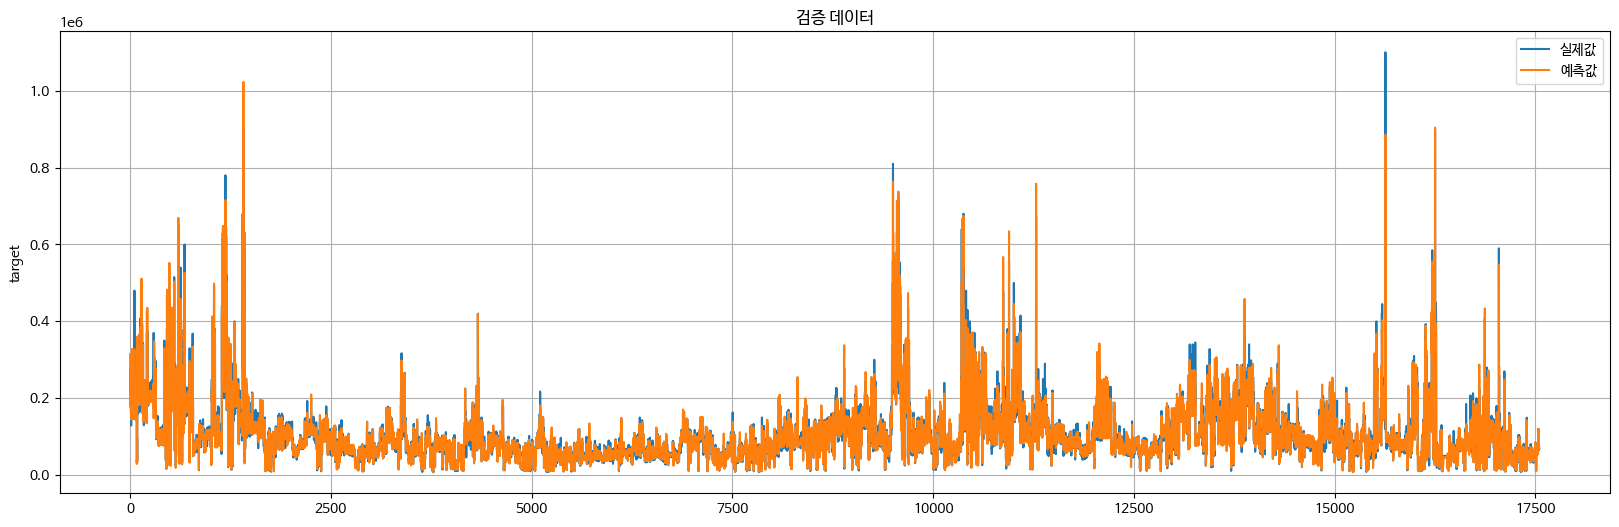

In [65]:
# 검증데이터에 대해서 모델이 얼마나 잘 맞추고 있는 시각화 해봅니다.
plt.figure(figsize=(20, 6))
plt.title("검증 데이터")
sns.lineplot(y_val.reset_index(drop=True), label='실제값', alpha=1)
sns.lineplot(pred, label='예측값', alpha=1)
plt.grid()
plt.show()

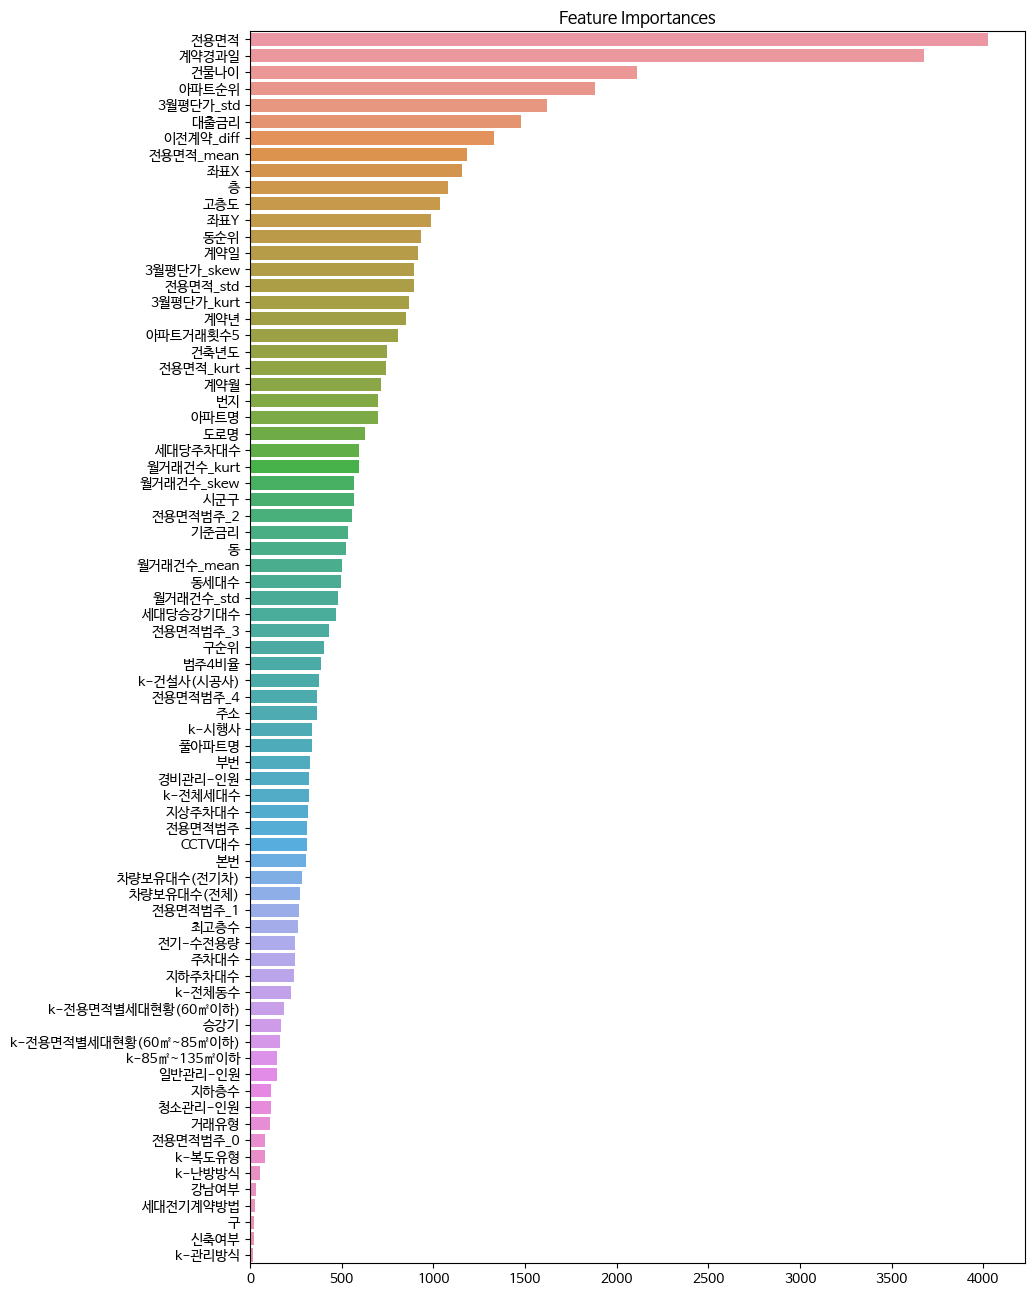

In [66]:
# feature importance를 시각화해봅니다.
importances = pd.Series(gbm_trained.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 16))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

## 8 최종 모델 학습
- 사전에 optuna를 통해 튜닝한 파라미터를 가지고 전체 데이터를 학습합니다.

In [67]:
best_params = {'reg_lambda': 23.992092231772162,
 'colsample_bytree': 0.6354347240922973,
 'subsample': 0.7460421356652953,
 'learning_rate': 0.06858418194202759,
 'num_leaves': 31,
 'max_depth': 12,
 'min_child_samples': 40}

best_model = lgb.LGBMRegressor(n_estimators=3328,                # early stopping을 적용하기에 적당히 많은 반복 횟수를 지정합니다.
                        metric="rmse",
                        data_sample_strategy='goss',        # sampling 방법을 goss로 적용합니다.
                        **best_params,
                        random_state=42,
                        )

best_model.fit(total_X_train, total_y_train,
        eval_set=[(total_X_train, total_y_train)],
        eval_metric ='rmse',
        categorical_feature="auto",
        callbacks=[lgb.early_stopping(stopping_rounds=50),         # early stopping을 적용합니다. 50번동안 metirc의 개선이 없다면 학습을 중단합니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]  # 10번의 반복마다 평가점수를 로그에 나타냅니다.
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13061
[LightGBM] [Info] Number of data points in the train set: 1118822, number of used features: 75
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 57991.532149
[10]	training's rmse: 27648.6
[20]	training's rmse: 17785
[30]	training's rmse: 13034.6
[40]	training's rmse: 10647.8
[50]	training's rmse: 9496.6
[60]	training's rmse: 8865.93
[70]	training's rmse: 8422.89
[80]	training's rmse: 8159.48
[90]	training's rmse: 7918.84
[100]	training's rmse: 7747.05
[110]	training's rmse: 7601.4
[120]	training's rmse: 7477.32
[13

LGBMRegressor(colsample_bytree=0.6354347240922973, data_sample_strategy='goss',
              learning_rate=0.06858418194202759, max_depth=12, metric='rmse',
              min_child_samples=40, n_estimators=3328, random_state=42,
              reg_lambda=23.992092231772162, subsample=0.7460421356652953)

In [68]:
# 학습한 모델을 저장합니다.
joblib.dump(best_model, 'gbm_final01.pkl')

['gbm_final01.pkl']

### 8.1 평가

In [69]:
# 검증 데이터에 대한 평가를 진행합니다.
# 최종 모델은 이미 검증 데이터를 학습에 활용하였기 때문에 신뢰성있는 평가가 불가능하지만 제대로 학습됐는지 확인 차원에서 RMSE를 구해봅니다. 
best_model_trained = joblib.load('gbm_final01.pkl')
pred = best_model_trained.predict(X_val)
RMSE = mean_squared_error(y_val, pred)**0.5

display(f"추론 결과 rmse : {RMSE:.4f}") 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


'추론 결과 rmse : 6468.6335'

In [70]:
# 평가 데이터에 대한 예측을 수행하고 시각해봅니다.
best_model_trained = joblib.load('gbm_final01.pkl')
# 테스트 데이터
X_test = dt_test.drop(columns=['target', '계약년월일'])

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = best_model_trained.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


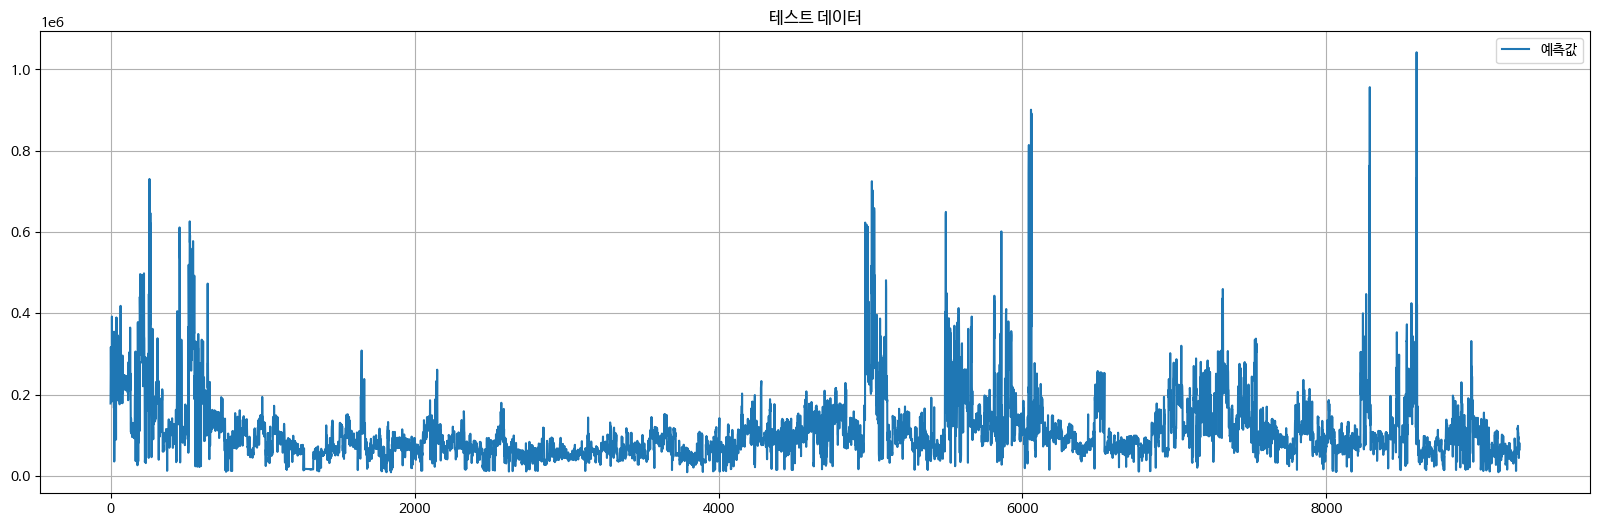

In [71]:
plt.figure(figsize=(20, 6))
plt.title("테스트 데이터")
sns.lineplot(real_test_pred, label='예측값', alpha=1)
plt.grid()
plt.show()

In [72]:
# 현재 학습된 모델이 전체적으로 조금 낮게 예측하는 경향이 있으며 부동산 데이터 특성상 시간에 비례해서 가격이 증가하는 특성이 있기때문에 약간의 가중치를 곱해줍니다.
# 전체를 곱함 or 분위95% 이상의 데이터 대해서만 곱함
def multi_pred(pred, weight, multi_all):
    
    final_pred = pd.DataFrame(pred, columns=['target'])
    
    if multi_all:
        modi_pred = final_pred['target'] * weight
    else:
        temp = final_pred[final_pred['target'] > final_pred['target'].quantile(0.95)]['target'] * weight
        final_pred.loc[temp.index, 'target'] = temp
        modi_pred = final_pred['target']
        
    return modi_pred

In [73]:
# 평가 데이터에 대해서 최종모델로 예측후 결과를 저장합니다.
X_test = dt_test.drop(columns=['target', '계약년월일'])

real_test_pred = best_model_trained.predict(X_test)
real_test_pred = multi_pred(real_test_pred, 1.03, True)

preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


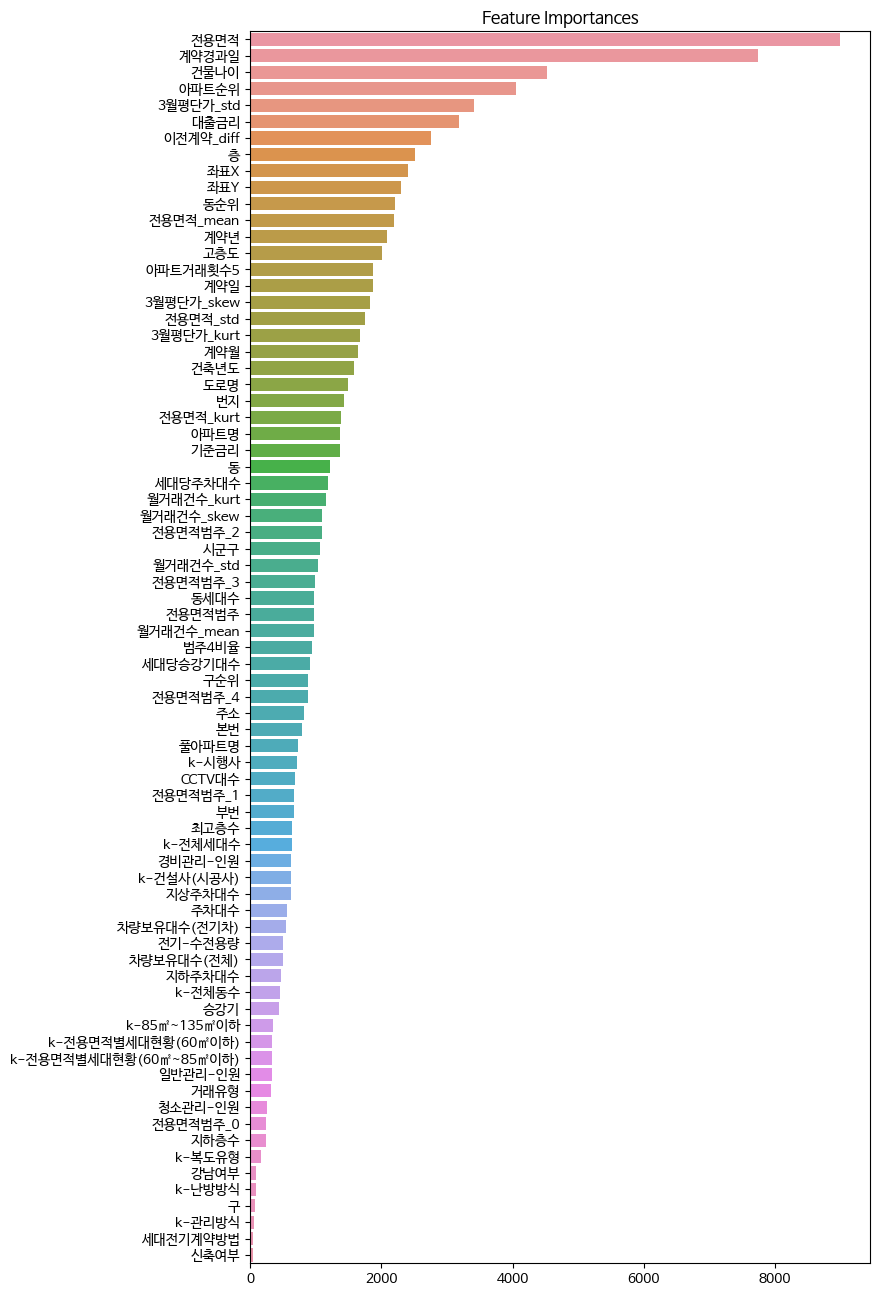

In [74]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model_trained.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8, 16))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

## 9 Valid prediction 해석

- 검증데이터에 대한 해석을 진행

In [75]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [76]:
# Squared_error를 계산
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [77]:
# Error가 큰 순서대로 sorting
X_val_sort = X_val.sort_values(by='error', ascending=False).copy()

In [78]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    X_val_sort[column] = label_encoders[column].inverse_transform(X_val_sort[column])
    
for en_map in encoing_maps:
    col, mapping = [item for item in en_map.items()][0]
    mapping = {v: k for k, v in mapping.items()}
    X_val_sort[col] = X_val_sort[col].map(mapping)
   

In [79]:
# 해석을 용이하기 위해 계약년월일 컬럼을 다시 추가해 줍니다.
X_val_sort['계약년월일'] = buy_date.loc[X_val_sort.index]

# 로그변환한 컬럼을 다시 되돌려줍니다.
if logTarget: X_val_sort['target'] = np.expm1(X_val_sort['target'])
if logArea: X_val_sort['전용면적'] = np.expm1(X_val_sort['전용면적'])

- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [80]:
error_top100 = X_val_sort.head(100)        # 예측을 잘 하지못한 top 100개의 data
best_top100 = X_val_sort.tail(100)       # 예측을 잘한 top 100개의 data

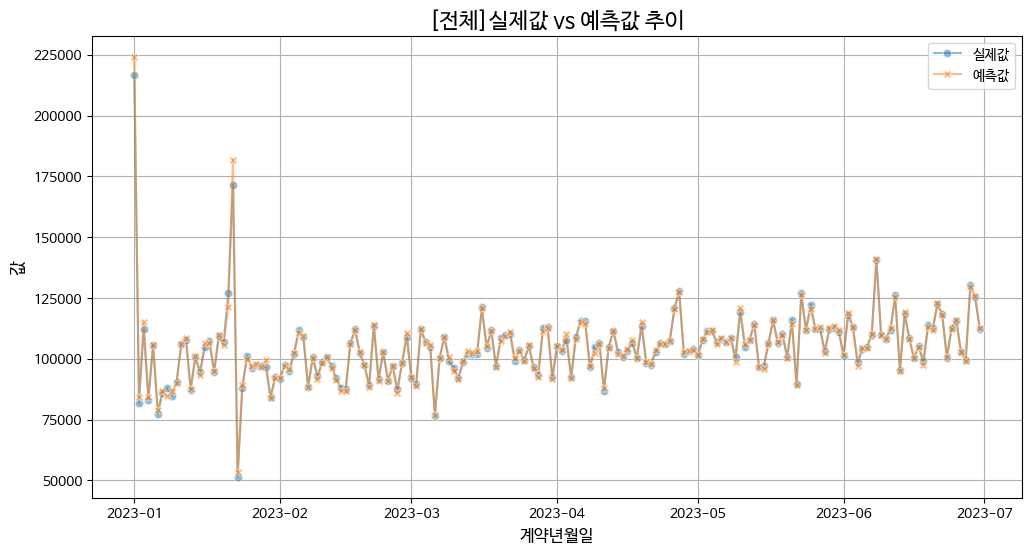

In [81]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=X_val_sort, y='target', x='계약년월일', label='실제값', alpha=0.5, ci=None, marker='o')
sns.lineplot(data=X_val_sort, y='pred', x='계약년월일', label='예측값', alpha=0.5, ci=None, marker='X')

plt.legend()

plt.title('[전체]실제값 vs 예측값 추이', fontsize=16)
plt.xlabel('계약년월일', fontsize=12)
plt.ylabel('값', fontsize=12)

plt.grid(True)
plt.show()

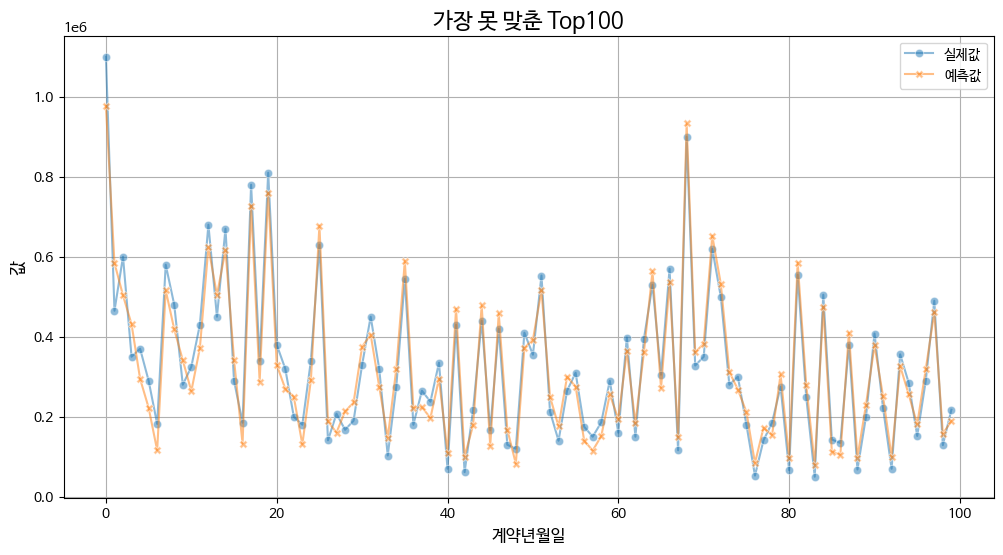

In [82]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=error_top100.reset_index(drop=True)['target'], label='실제값', alpha=0.5, ci=None, marker='o')
sns.lineplot(data=error_top100.reset_index(drop=True)['pred'], label='예측값', alpha=0.5, ci=None, marker='X')

plt.legend()

plt.title('가장 못 맞춘 Top100', fontsize=16)
plt.xlabel('계약년월일', fontsize=12)
plt.ylabel('값', fontsize=12)

plt.grid(True)

plt.show()

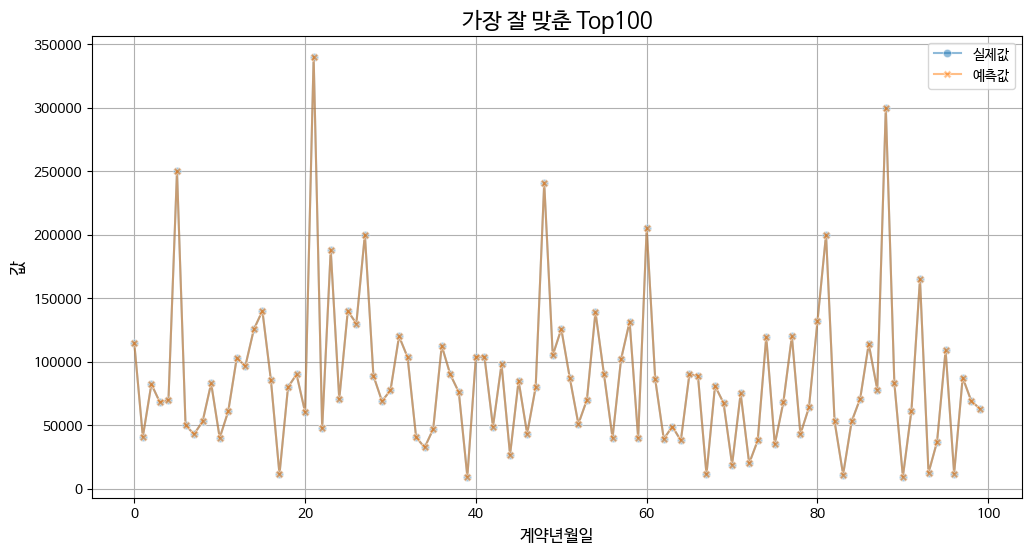

In [83]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=best_top100.reset_index(drop=True)['target'], label='실제값', alpha=0.5, ci=None, marker='o')
sns.lineplot(data=best_top100.reset_index(drop=True)['pred'], label='예측값', alpha=0.5, ci=None, marker='X')

plt.legend()

plt.title('가장 잘 맞춘 Top100', fontsize=16)
plt.xlabel('계약년월일', fontsize=12)
plt.ylabel('값', fontsize=12)

plt.grid(True)
plt.show()

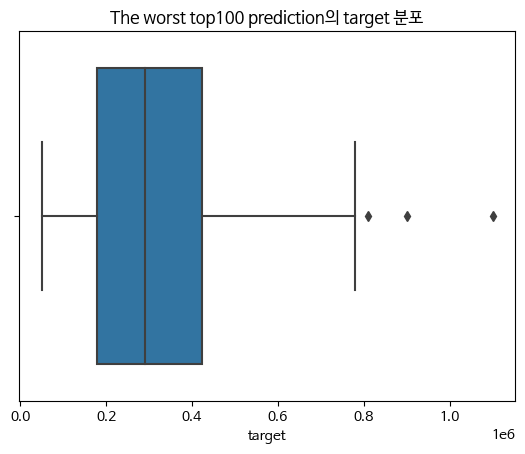

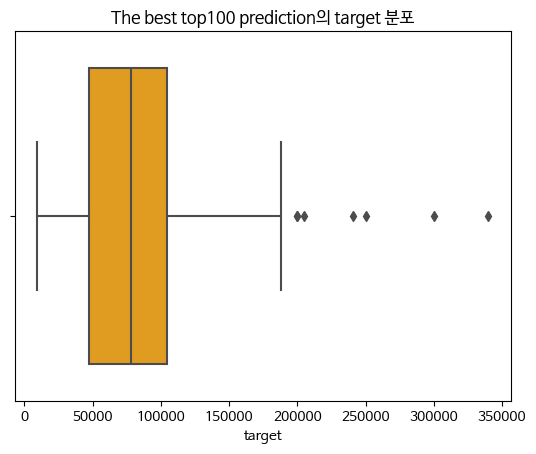

In [84]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- 대체적으로 높은 가격의 아파트를 잘 맞추짐 못하는 것으로 보입니다.

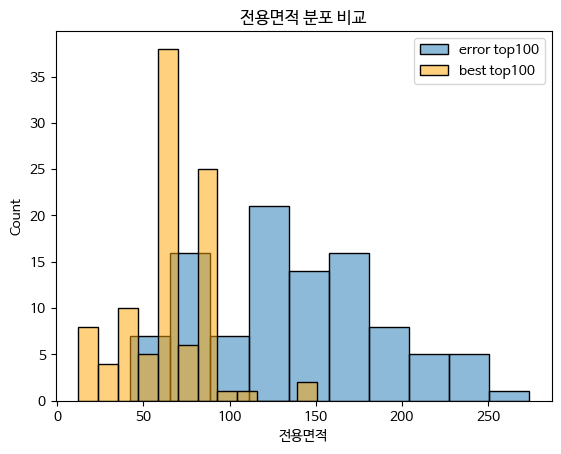

In [85]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5, label="error top100")
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5, label="best top100")
plt.title('전용면적 분포 비교')
plt.legend()
plt.show()

- 전용면적이 작은 아파트에 대해서는 잘 맞추지만 전용면적이 큰 아파트에 대해서는 잘 맞추지 못하는 모습입니다.